In [1]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import numpy as np
from optax import adam

import matplotlib.pyplot as plt
from skimage.data import cells3d

from chromatix import Field, Microscope
from chromatix.elements import ObjectivePointSource, PhaseMask, FFLens, SeidelAberrations
from chromatix.functional.phase_masks import defocused_ramps, seidel_aberrations
from chromatix.ops.noise import shot_noise
from chromatix.ops.ops import downsample
from chromatix.ops.windows import sigmoid_taper
from chromatix.utils import center_crop
from chromatix.utils import trainable


from typing import Callable, Optional, Tuple
from chex import Array

key = random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
camera_shape: Tuple[int, int] = (256, 256)
camera_pixel_pitch: float = 0.125
f: float = 100
NA: float = 0.8
n: float = 1.
wavelength: float = 0.532
wavelength_ratio: float = 1.0
upsample: int = 4
pad: int = 128
taper_width: Optional[float] = 5
noise_fn: Callable = shot_noise

In [3]:
shape = tuple(np.array(camera_shape) * upsample + pad)
spacing = upsample* f * wavelength/ (n * shape[0] * camera_pixel_pitch)

print(f"Shape of simulation: {shape}")
print(f"Spacing of simulation: {spacing:.2f}")

Shape of simulation: (1152, 1152)
Spacing of simulation: 1.48


Text(0.5, 1.0, 'Initial phase of SLM')

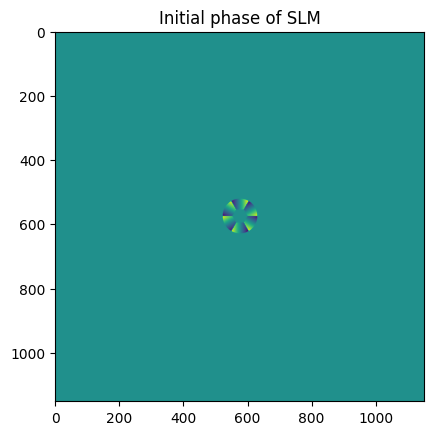

In [4]:
init_phase = defocused_ramps(tuple([1]) + shape + tuple([1]), spacing, wavelength, n, f, NA)
plt.imshow(init_phase.squeeze())
plt.title("Initial phase of SLM")

Text(0.5, 1.0, 'Initial phase of SLM')

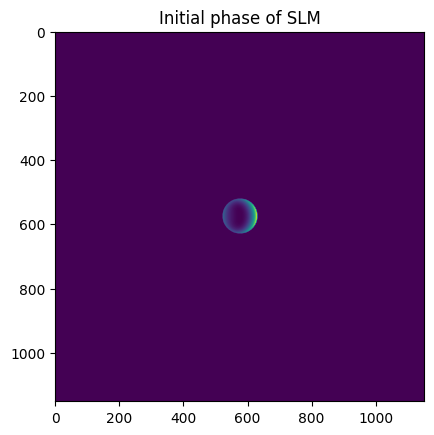

In [56]:
init_phase = seidel_aberrations(tuple([1]) + shape + tuple([1]), spacing, wavelength, n, f, NA, coefficients=tuple([5,5,5,0,0]), u=1, v=0)
plt.imshow(init_phase.squeeze())
plt.title("Initial phase of SLM")

In [57]:
coefficients=jnp.array([5.,5,5,0,0])
system = [ObjectivePointSource(shape, spacing, wavelength, wavelength_ratio, f, n, NA, power=1e7),
          SeidelAberrations(coefficients, f, n, NA, 0, 1),
          FFLens(f, n)]

model = Microscope(system, noise_fn=None, reduce_fn=lambda x: jnp.sum(x, axis=0, keepdims=True))
params = model.init({"params": key, "noise": key}, z=jnp.zeros((5, )), method=model.psf) # zeros is just for shape inference

In [58]:
def post_process_psf(psf: Array) -> Array:
    psf = center_crop(psf, (None, pad // 2, pad // 2, None))
    psf = downsample(psf, (upsample, upsample))
    return psf * sigmoid_taper(camera_shape, taper_width)

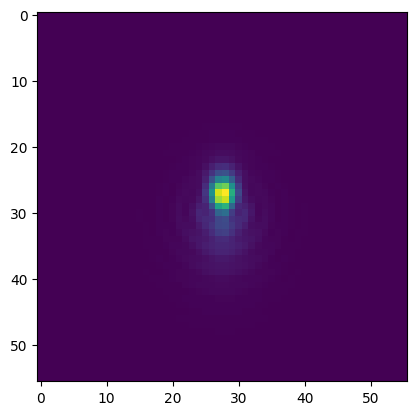

In [59]:
psf_truth = model.apply(params, 0, method=model.psf)
psf = post_process_psf(psf_truth)
plt.imshow(psf.squeeze()[100:-100,100:-100])

In [60]:
@jax.jit
def generate_image(params, z, data):
    # We get the downsampled psf
    psf = model.apply(params, z, method=model.psf)
    psf = post_process_psf(psf)

    # And image with that
    return model.apply(params, psf, data, method=model.image, rngs={"noise": key}) # need rngs for reproducible noise.

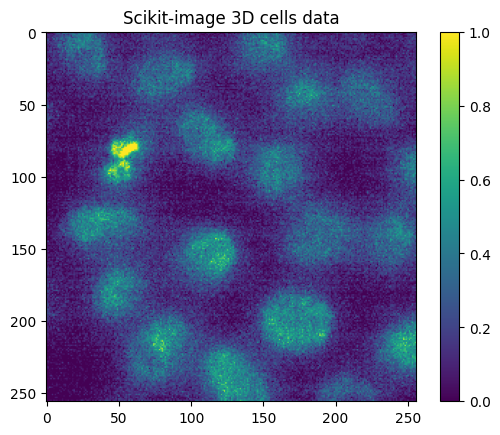

In [61]:
data = cells3d()[:, 1, ..., None]

# Rescale image data to range [0, 1]
data = jnp.clip(data, jnp.percentile(data, 5), jnp.percentile(data, 95))
data = (data - data.min()) / (data.max() - data.min())

# Plotting the data - TODO: get better version from scikit image
plt.imshow(data[20].squeeze())
plt.title("Scikit-image 3D cells data")
plt.colorbar()
plt.show()


In [62]:
image = generate_image(params, 0, data[20:21])

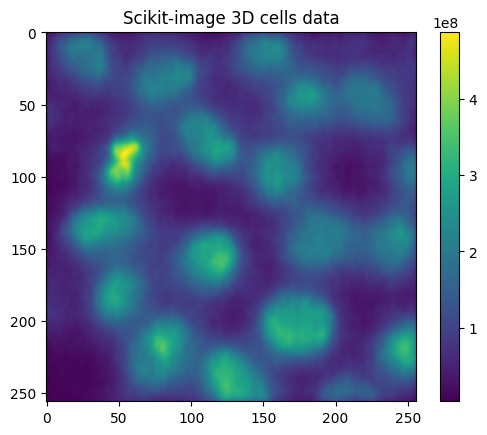

In [63]:
plt.imshow(image.squeeze())
plt.title("Scikit-image 3D cells data")
plt.colorbar()
plt.show()

In [64]:

init_coeffs=jnp.array([0.,0,0,0,0])

class SeidelPSF(nn.Module):
    @nn.compact
    def __call__(self, z, u, v):
        # Parameters are taken from the paper, we just use 256, 256 because of our data 
        field  = ObjectivePointSource(shape, spacing, wavelength, wavelength_ratio, f, n, NA, power=1e7)(z)
        field = SeidelAberrations(trainable(init_coeffs), f, n, NA, u, v)(field)
        field = FFLens(f, n)(field) # TODO: Add padding to FFLens
        return field
    
    
    

In [65]:
model = SeidelPSF()
params = model.init(key, 0, 0, 0)
output_field = model.apply(params, z=0, u=0, v=0)
print(params)

FrozenDict({
    params: {
        SeidelAberrations_0: {
            seidel_coefficients: Array([0., 0., 0., 0., 0.], dtype=float32),
        },
    },
})


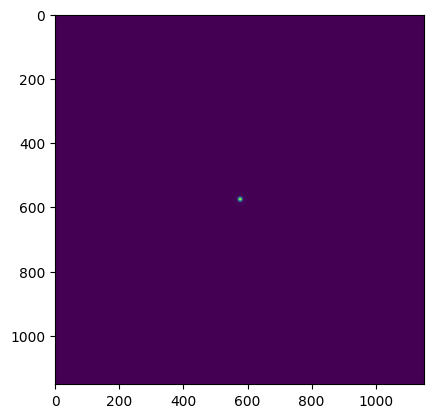

In [66]:
plt.imshow(output_field.intensity.squeeze())
plt.show()

In [67]:
import pdb
def loss_fn(params, data, z, u, v):
    eps = 1e-6
    psf_estimate = model.apply(params, z=z, u=u, v=v).intensity.squeeze()
    loss = jnp.mean(jnp.square(psf_estimate - data.squeeze()))
    return loss, {"loss": loss}

print(loss_fn(params, psf_truth, 0,0,1))

(Array(1.0675891e+11, dtype=float32), {'loss': Array(1.0675891e+11, dtype=float32)})


In [68]:
grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True)) # jit compiles and makes everything go brrrrr
#print(grad_fn(params, data, z, u, v)[0]["params"]["PhaseMask_0"]["phase_pixels"][0, :4, :4, 0])
print(grad_fn(params, psf_truth, 0, 0, 1))

(FrozenDict({
    params: {
        SeidelAberrations_0: {
            seidel_coefficients: Array([6.673408e+03, 4.791057e+09, 4.902912e+03, 7.490560e+03,
                   7.986666e+09], dtype=float32),
        },
    },
}), {'loss': Array(1.0675896e+11, dtype=float32)})


In [84]:
optimizer = adam(learning_rate=0.5)
opt_state = optimizer.init(params)
def step_fn(loss_fn, optimizer):
    def step(params, opt_state, *args):
        (_, metrics), grads = jax.value_and_grad(loss_fn, allow_int=True, has_aux=True)(
            params, *args
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, metrics
    return step

step = jax.jit(step_fn(loss_fn, optimizer))

In [85]:
%%time
model = SeidelPSF()
params = model.init(key, 0, 0, 0)
# Now we train
max_iterations = 1000 # only 1000 as I'm running on my laptop
history = []
for iteration in range(max_iterations):
    params, opt_state, metrics = step(params, opt_state, psf_truth, 0,0,1)
    history.append(metrics["loss"])
    if iteration % 100 == 0:
        print(iteration, metrics)
        

0 {'loss': Array(1.0675896e+11, dtype=float32)}
100 {'loss': Array(76260368., dtype=float32)}
200 {'loss': Array(33686900., dtype=float32)}
300 {'loss': Array(11602533., dtype=float32)}
400 {'loss': Array(3194694.2, dtype=float32)}
500 {'loss': Array(711734.6, dtype=float32)}
600 {'loss': Array(128368.26, dtype=float32)}
700 {'loss': Array(18653.611, dtype=float32)}
800 {'loss': Array(2167.6091, dtype=float32)}
900 {'loss': Array(199.62938, dtype=float32)}
CPU times: user 3min 43s, sys: 53.2 s, total: 4min 36s
Wall time: 2min 4s


In [86]:
params

FrozenDict({
    params: {
        SeidelAberrations_0: {
            seidel_coefficients: Array([-4.9993100e+00,  5.0000730e+00, -4.9999475e+00, -6.8872567e-04,
                    1.6195896e-05], dtype=float32),
        },
    },
})